KHAI BÁO THƯ VIỆN

In [58]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import joblib
from sklearn.svm import SVC
import torch
from sklearn.decomposition import PCA


In [59]:
seed = 42
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

Using device: cuda


LOAD DATASET

In [60]:
x_train_scaled_loaded = joblib.load('../data/multi_class/x_train_scaled_multi_class.pkl')
x_test_scaled_loaded  = joblib.load('../data/multi_class/x_test_scaled_multi_class.pkl')
y_train_loaded        = joblib.load('../data/multi_class/y_train_multi_class.pkl')
y_test_loaded         = joblib.load('../data/multi_class/y_test_multi_class.pkl')
le = joblib.load("../data/multi_class/label_encoder.pkl")

In [61]:
x_train_scaled_loaded = x_train_scaled_loaded.to_numpy()
x_test_scaled_loaded  = x_test_scaled_loaded.to_numpy() 
y_train_loaded = y_train_loaded.to_numpy()
y_test_loaded  = y_test_loaded.to_numpy()

In [62]:
print (x_train_scaled_loaded.shape)
print (y_train_loaded.shape)

print (x_test_scaled_loaded.shape)
print (y_test_loaded.shape)

(8012, 27)
(8012,)
(2003, 27)
(2003,)


SVM without hyperparameter

In [63]:
svm_model1 = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, class_weight='balanced')  
svm_model1.fit(x_train_scaled_loaded, y_train_loaded)
svm_model1.score(x_test_scaled_loaded , y_test_loaded)

0.6125811283075387

In [64]:
y_pred = svm_model1.predict(x_test_scaled_loaded)
precision = precision_score(y_test_loaded, y_pred, average='macro') 
recall = recall_score(y_test_loaded, y_pred, average='macro')
f1 = f1_score(y_test_loaded, y_pred, average='macro')

print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")

Precision : 0.3748
Recall    : 0.5448
F1-score  : 0.3763


""" 
Precision = 0.3748
→ Model đoán sai rất nhiều
Các lớp nhỏ (df, vasc, healthy) bị nuốt vào các lớp lớn
Khi model dự đoán “lớp hiếm” → đa phần là sai

Recall = 0.5448
→ Model bắt được ~54% mẫu thật
Nhờ class_weight='balanced' → model cố gắng đoán các lớp hiếm, nhưng đoán không chính xác
"""

DÙNG OPTUNA ĐỂ TÌM RA BỘ SIÊU THAM SỐ

In [65]:
def objective(trial):
    C = trial.suggest_loguniform('C', 1e-3, 1e3)  # Tham số điều chỉnh độ phạt
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf','poly'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto',0.01, 0.001])
    degree = trial.suggest_int('degree', 2, 3)  # Bậc của đa thức nếu kernel='poly'

    model = SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
        degree=degree,
        class_weight='balanced', 
        random_state=42,
        decision_function_shape="ovr" # SVM đa lớp sử dụng one-vs-rest
    )

    cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42
    )

    score = cross_val_score(
        model,
        x_train_scaled_loaded,
        y_train_loaded,
        cv=cv,
        scoring="f1_macro"  # Sử dụng F1_macro để đánh giá mô hình một cách công bằng cho mọi lớp, không thiên vị lớp đông mẫu.
    ).mean()

    return score


In [66]:
"""
scoring="f1_macro": 
- Trung bình F1 của từng lớp (không trọng số)
- Đánh giá một cách công bằng cho mọi lớp, không thiên vị lớp đông mẫu.

class_weight='balanced':
- Lớp hiếm → trọng số lớn hơn
- Sai 1 mẫu lớp hiếm → phạt nặng hơn

average='macro':
- Tính precision / recall / F1 riêng từng lớp
- Lấy trung bình không trọng số
- Cân bằng giữa các bệnh

"""

'\nscoring="f1_macro": \n- Trung bình F1 của từng lớp (không trọng số)\n- Đánh giá một cách công bằng cho mọi lớp, không thiên vị lớp đông mẫu.\n\nclass_weight=\'balanced\':\n- Lớp hiếm → trọng số lớn hơn\n- Sai 1 mẫu lớp hiếm → phạt nặng hơn\n\naverage=\'macro\':\n- Tính precision / recall / F1 riêng từng lớp\n- Lấy trung bình không trọng số\n- Cân bằng giữa các bệnh\n\n'

In [67]:
# Tạo một study Optuna để tối ưu hóa siêu tham số cho mô hình SVC
# Sử dụng thuật toán TPE với seed=42 để đảm bảo tính tái lập
# direction='maximize' nghĩa là muốn tối đa hóa giá trị trả về từ objective 

study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))

# objective là hàm mục tiêu đã định nghĩa ở trên, trả về độ chính xác trung bình qua cross-validation

study.optimize(objective, n_trials=10) # chọn 10 lần vì máy không chạy nổi khi quá 10 lần :(((


[I 2026-02-02 22:30:45,407] A new study created in memory with name: no-name-623e5521-1c26-4bc5-8abc-4c94edd8d6b8
C:\Users\PC\AppData\Local\Temp\ipykernel_12336\944228168.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)  # Tham số điều chỉnh độ phạt
[I 2026-02-02 22:30:48,252] Trial 0 finished with value: 0.3295386141034313 and parameters: {'C': 0.1767016940294795, 'kernel': 'linear', 'gamma': 0.001, 'degree': 3}. Best is trial 0 with value: 0.3295386141034313.
C:\Users\PC\AppData\Local\Temp\ipykernel_12336\944228168.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)  # Tham số

In [68]:
best_params_from_optuna = study.best_params
best_params_from_optuna

{'C': 3.8672288491177444, 'kernel': 'linear', 'gamma': 0.01, 'degree': 3}

In [69]:
"""
- Lấy best_C từ Optuna làm trung tâm
- Tìm thêm 5 giá trị C xung quanh (log-scale)
- Giữ kernel, degree, gamma
"""

param_grid = {
    'C': np.logspace(
        np.log10(best_params_from_optuna['C']) - 0.5,
        np.log10(best_params_from_optuna['C']) + 0.5,
        5
    )
}

svm_model = SVC(
    class_weight='balanced',
    random_state=42,
    decision_function_shape='ovr'
)


cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42,
)

# Thiết lập GridSearchCV với mô hình SVC và lưới siêu tham số
clf = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    cv=cv,
    verbose=0,
    n_jobs=-1,
    scoring='f1_macro' 
)

best_svm = clf.fit(x_train_scaled_loaded, y_train_loaded)

ĐÁNH GIÁ MÔ HÌNH

In [70]:
y_pred = best_svm.predict(x_test_scaled_loaded)
print(y_pred)

[1 4 4 ... 4 3 4]


In [71]:
print(le.classes_)

['Actinic keratoses' 'Basal cell carcinoma' 'Benign keratosis'
 'Dermatofibroma' 'Melanocytic nevus' 'Melanoma' 'Vascular lesions']


Accuracy : 0.6255616575137294
Precision : 0.38325751023430155
Recall : 0.5517874653808293
F1-score : 0.3937311250992405

Classification Report:
                      precision    recall  f1-score   support

   Actinic keratoses       0.26      0.75      0.39        65
Basal cell carcinoma       0.20      0.45      0.27       103
    Benign keratosis       0.57      0.27      0.36       220
      Dermatofibroma       0.12      0.65      0.20        23
   Melanocytic nevus       0.97      0.72      0.83      1341
            Melanoma       0.36      0.45      0.40       223
    Vascular lesions       0.21      0.57      0.30        28

            accuracy                           0.63      2003
           macro avg       0.38      0.55      0.39      2003
        weighted avg       0.78      0.63      0.67      2003



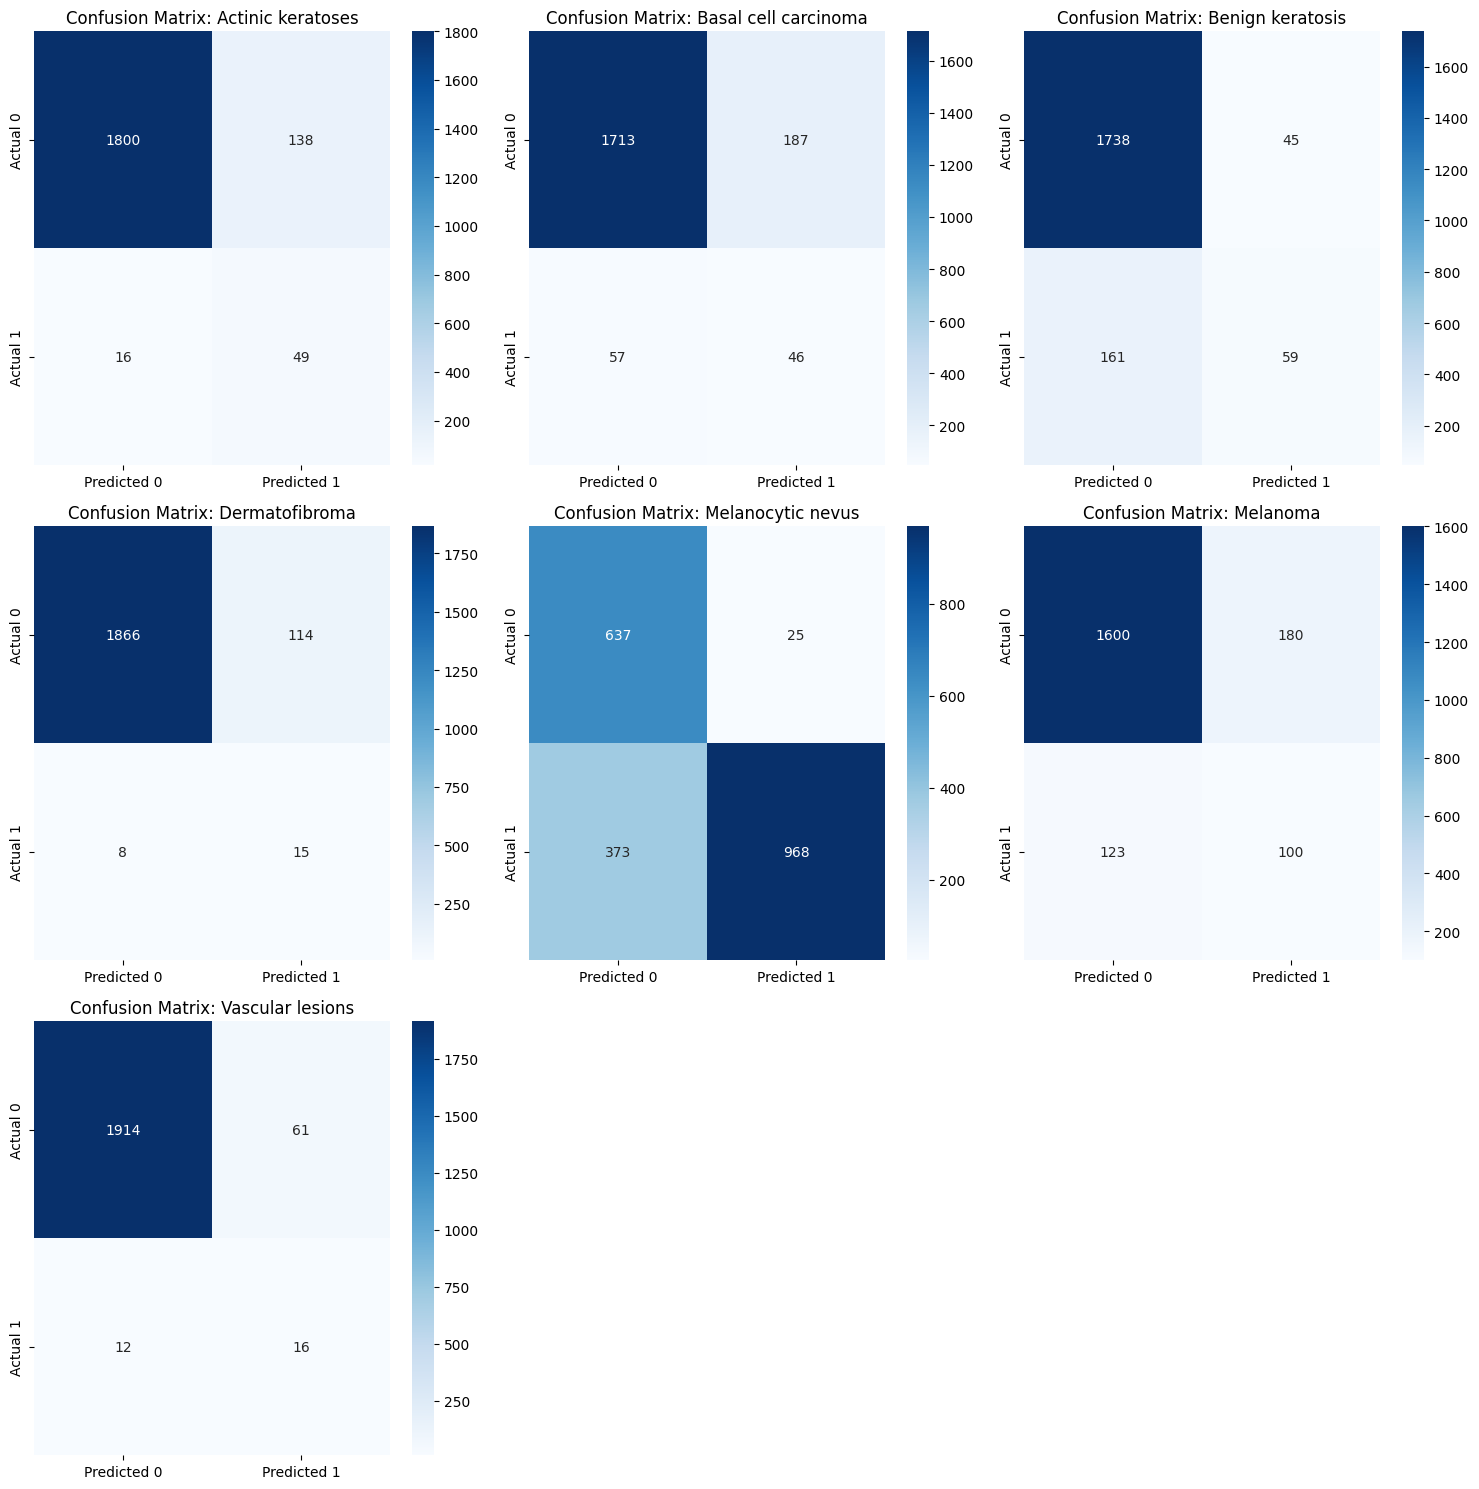

In [72]:
accuracy = accuracy_score(y_test_loaded, y_pred)
precision = precision_score(y_test_loaded, y_pred, average="macro")
recall = recall_score(y_test_loaded, y_pred, average="macro")
f1 = f1_score(y_test_loaded, y_pred, average="macro")

print("Accuracy :", accuracy)
print("Precision :", precision)
print("Recall :", recall)
print("F1-score :", f1)

# 3. Classification Report (từng lớp)
print("\nClassification Report:")
print(classification_report(
    y_test_loaded,
    y_pred,
    target_names=le.classes_
))

# 4. Confusion Matrix (7x7)
class_names = le.classes_
n_classes = len(class_names)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, class_name in enumerate(class_names):
    # One-vs-Rest ground truth & prediction
    y_true_binary = (y_test_loaded == i).astype(int)
    y_pred_binary = (y_pred == i).astype(int)

    cm = confusion_matrix(y_true_binary, y_pred_binary)

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=axes[i],
        xticklabels=['Predicted 0', 'Predicted 1'],
        yticklabels=['Actual 0', 'Actual 1']
    )

    axes[i].set_title(f"Confusion Matrix: {class_name}")

for j in range(n_classes, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [73]:
"""
Accuracy = 0.63 =>Không thấp, nhưng không đáng tin vì dữ liệu imbalance

Macro-F1 = 0.39:
- Mỗi lớp được đánh giá công bằng
- Model chưa học tốt các lớp hiếm

PHÂN TÍCH TỪNG LỚP:

***Melanocytic nevus (lớp đông nhất)
Precision: 0.97
Recall: 0.72
F1: 0.83
=> Model học rất tốt lớp này

***Nhóm lớp trung bình (Benign keratosis, Melanoma)
F1 ≈ 0.36 – 0.40
Recall ~ 0.27 – 0.45
=> Model còn nhầm lẫn chéo nhiều

***Nhóm lớp hiếm (df, vasc, akiec, bcc)
Recall khá cao → model cố gắng bắt lớp hiếm
Precision rất thấp → nhiều false positive


=> Mặc dù SVM với class weighting giúp cải thiện recall cho các lớp hiếm, 
mô hình vẫn gặp khó khăn trong việc phân tách ranh giới quyết định giữa các bệnh có đặc trưng lâm sàng tương tự, 
dẫn đến precision thấp và macro-F1 còn hạn chế.

"""

'\nAccuracy = 0.63 =>Không thấp, nhưng không đáng tin vì dữ liệu imbalance\n\nMacro-F1 = 0.39:\n- Mỗi lớp được đánh giá công bằng\n- Model chưa học tốt các lớp hiếm\n\nPHÂN TÍCH TỪNG LỚP:\n\n***Melanocytic nevus (lớp đông nhất)\nPrecision: 0.97\nRecall: 0.72\nF1: 0.83\n=> Model học rất tốt lớp này\n\n***Nhóm lớp trung bình (Benign keratosis, Melanoma)\nF1 ≈ 0.36 – 0.40\nRecall ~ 0.27 – 0.45\n=> Model còn nhầm lẫn chéo nhiều\n\n***Nhóm lớp hiếm (df, vasc, akiec, bcc)\nRecall khá cao → model cố gắng bắt lớp hiếm\nPrecision rất thấp → nhiều false positive\n\n\n=> Mặc dù SVM với class weighting giúp cải thiện recall cho các lớp hiếm, \nmô hình vẫn gặp khó khăn trong việc phân tách ranh giới quyết định giữa các bệnh có đặc trưng lâm sàng tương tự, \ndẫn đến precision thấp và macro-F1 còn hạn chế.\n\n'

LƯU MODEL

In [74]:
joblib.dump(best_svm, "../model/svm_multi_class_model.joblib")

['../model/svm_multi_class_model.joblib']